# Solving the Max-Cut Problem with LunaSolve

In this notebook, we'll explore how to tackle the **MaxvCut** problem using LunaSolve. First, we'll introduce and explain the Max-Cut problem through a straightforward example. Then, we'll walk step-by-step through modeling a real-world instance, optimizing the solution, and finally interpreting the results provided by LunaSolve.

## Table of Contents

1. [Introduction](#1)
2. [A Real-World Example](#2)
3. [Solving the Max-Cut with LunaSolve](#3)


<a id="1"></a>
## 1. Introduction to Max-Cut

### What is Max-Cut?

The **Max-Cut** problem is a classic problem in combinatorial optimization and graph theory. Simply put, given a graph $G$, the goal is to divide the nodes of $G$ into two distinct groups, $A$ and $B$, so that the number of connections (edges) between these two groups is maximized.

Let's define this formally:

Suppose we have an undirected graph $G = (V, E)$, where $V$ represents vertices (nodes) and $E$ represents edges (connections). A cut is created when we partition the nodes in $V$ into two separate subsets, $A$ and $B$. The Max-Cut problem seeks the partition that maximizes the number of edges between these two groups.

While this might initially sound abstract, consider it this way: how can we divide a network into two groups to maximize the interaction across the groups?

<a id="2"></a>
## 2. A Real-World Example

To better understand the Max-Cut problem, let's look at an everyday scenario. Imagine a company wants to distribute promotional samples strategically to maximize word-of-mouth marketing.

In this scenario, each person represents a node, and friendships between people are represented as edges. Naturally, friends talk to each other, increasing the chances they'll discuss the new product.

The company's aim is to split their audience into two groups, group A and group B, in a way that maximizes the number of friendships (edges) between the two groups. This maximizes cross-group communication, amplifying the product's exposure without needing to distribute too many free samples. Typically, the smaller group might receive the samples, encouraging them to share their experiences with friends in the larger group.

This practical example illustrates clearly why Max-Cut is more than just a theoretical puzzle, rather it can be a useful tool for strategic decision-making in business and beyond.


<a id="3"></a>
## 3. Solving the Max-Cut problem with Luna

To follow along with the next steps, you'll need the following three libraries:
1. **luna_quantum** for modeling and solving our optimization problem,
2. **matplotlib** for visualizing the results, and
3. **networkx** for creating and displaying the graphs.

Run the cell below to install these libraries automatically if they aren't already installed.

In [ ]:
# Install the python packages that are needed for the notebook
%pip install --upgrade pip
%pip install luna_quantum --upgrade
%pip install matplotlib networkx

### 3.1 Setting Up the Luna Client

Now let's dive into solving the Max-Cut problem using LunaSolve. First, you'll instantiate a LunaSolve object and configure your credentials. The API key identifies your account and grants access to Luna's services. You can find your API key in your Aqarios account settings.

In [2]:
from luna_quantum import LunaSolve
import getpass
import os

if "LUNA_API_KEY" not in os.environ:
    # Prompt securely for the key if not already set
    os.environ["LUNA_API_KEY"] = getpass.getpass("Enter your Luna API key: ")

ls = LunaSolve()

In [ ]:
from luna_quantum import Logging
import logging

Logging.set_level(logging.WARNING)

If you haven't yet configured a QPU token for your account, or if you'd like to add a new one, you can do so using the `ls.qpu_token.create()` method. However, in this tutorial we will be using a classical solver from Dwave, which does not require one.

### 3.2 Creating a Max-Cut Problem

To create a Max-Cut instance, we just need a graph with vertices and edges. Here, we'll build a graph representing friendships among nine individuals, labeled 0 through 8. Friendships between individuals are shown as edges connecting the nodes. After creating the graph, we'll visualize it to clearly illustrate these relationships.

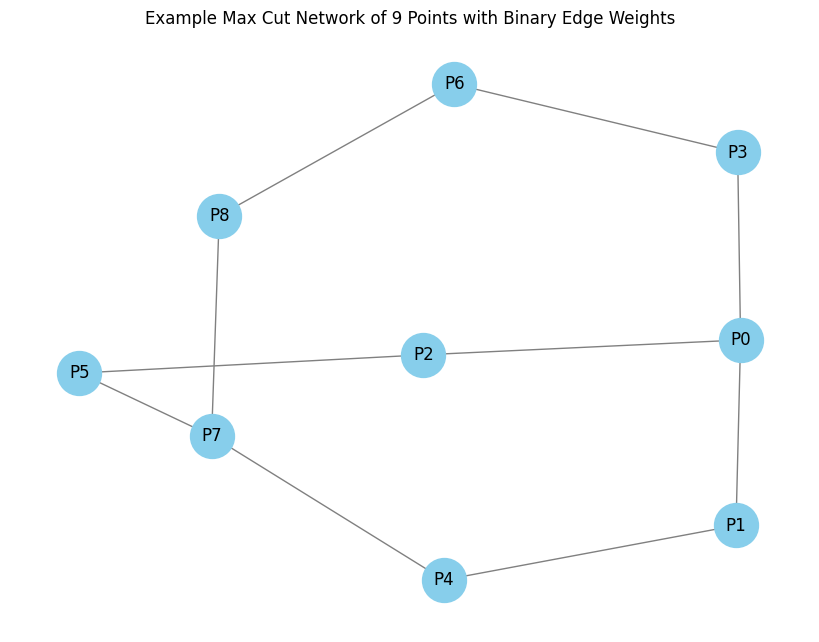

In [4]:
# Import the necessary packages
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph 
max_cut_graph = nx.Graph()

# Add the nodes of the graph, which represent the people of the example friendship network.
nodes = ["P0", "P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8"]
max_cut_graph.add_nodes_from(nodes)

# Add the edges to the graph, which represent the friendships between the people.
edges = [
    ("P0", "P1"), ("P0", "P2"), ("P0", "P3"),
    ("P1", "P4"), ("P2", "P5"), ("P3", "P6"),
    ("P4", "P7"), ("P5", "P7"), ("P6", "P8"),
    ("P7", "P8")
]
max_cut_graph.add_edges_from(edges)

# Draw the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(max_cut_graph)  
nx.draw(max_cut_graph, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=1000, font_size=12)
plt.title("Example Max-Cut Network of 9 Points with Binary Edge Weights")
plt.show()

### 3.3 Defining a Max-Cut Object

The graph we've created represents a network of friendships. To identify the best way to partition this network, we'll define the Max-Cut problem using LunaSolve's `MaxCut` class. This class converts the problem instance into an optimization problem, which Luna can then optimize.

When initializing the `MaxCut` object, ensure you pass the graph as a dictionary using NetworkX's `nx.to_dict_of_dicts()` method. Optionally, you can provide a descriptive `name` for your instance, if not specified, LunaSolve defaults it to `MC` for MaxCut.

In [5]:
# Import the MaxCut object from the luna sdk
from luna_quantum.solve.use_cases import MaxCut

# Create a MaxCut object, to use within the luna_sdk for optimisation
max_cut = MaxCut(graph=nx.to_dict_of_dicts(max_cut_graph))

### 3.4 Uploading the Use Case Model to Luna 

Now, let's upload our Max-Cut problem to Luna. We can use LunaSolve's `ls.model.create_from_use_case()` method and provide the use case object we just defined and assign a clear, identifiable `name` to the optimization.

In [6]:
# Initiliaze the optimization object using the created use case instance
model = ls.model.create_from_use_case(name="Max-Cut", use_case=max_cut)

### 3.5 Choose an Algorithm and Run It

The final step is to create a job request, sending our optimization task to the hardware provider to solve. To successfully create a job, we must first select an algorithm for the optimization from LunaSolve's collection, specify the algorithm's parameters and select a backend for the algorithm to run on.

In this instance, we solve the Max-Cut problem using simulated annealing (sa) and choose D-Wave (dwave) as the hardware provider. Simulated annealing has multiple parameters which can be adjusted to fine-tune the exact optimization. Here we are going to set the `num_reads` equal to 1000. This means that the annealing process is done 1000 times, returning 1000 sampled results.

Lastly, we execute the job by calling the `algorithm.run()` method and passing the `model` together with a chosen `name`for the job for easy identification. 

In [7]:
from luna_quantum.solve.parameters.algorithms import SimulatedAnnealing
from luna_quantum.solve.parameters.backends import DWave

#Select the SimulatedAnnealingSolver algorithm.
algorithm = SimulatedAnnealing(
    backend=DWave(),
    num_reads=1000, 
)

# Execute an outbound solve request.
job = algorithm.run(model.id, name="Max-Cut with SA")

### 3.6 Retrieving the Solution

In step 3.4, we uploaded our problem, and in step 3.5, we sent a solution request to Luna. Luna automatically manages the subsequent background processes. This includes preparing the optimization problem, converting it into the correct format for the quantum hardware provider, submitting the problem to the quantum computer, and finally retrieving and translating the solution back into a user-friendly format.

Now let's discuss the final stages: retrieving the solution, converting it back to our original problem representation, and interpreting the results.

First, we'll use the `job.result()` method to fetch our results. The returned `Solution` object contains several attributes related to the optimization, including metadata such as the `runtime`, the `count` (how often each sample occurred), the `objective_value` and `raw_energies` of each sample. To learn more about the `Solution` Object visit Luna's thorough documentation.

In [ ]:
solution = job.result()

The `Solution` object returns the sampled solutions in the native optimization format of the provider's solver together with its metadata. To interpret the solutions quicker, LunaSolve provides automatic post-processing functions which decode the samples back into an intuitive and easy-to-read format as below.

You can use the `job.get_use_case_representation_result()` method to retrieve the decoded form of the solution. This returns the solution in a readable format, with a few key components:

- The `sense` attribute indicates whether our objective is to maximize or minimize the target function.
- The `result` is typically an iterable containing the `representation` (the solution itself) and the corresponding `obj_value` (objective value). While the objective value can be complex due to embedded constraint penalties, generally, smaller values signify better solutions for minimization problems and vice versa for maximization problems.
- The `description` helps clarify the format of the returned `representation`.

In the case of the Max-Cut problem, the `representation` is a tuple of lists. Each list contains the indices of all nodes that are included in the two partitions according to the selected cut. In other words, the representation is a set of two lists. One containing all indices $i$, for which their decision variable $x_i$ is equal to one. And the other contains all indices $i$, for which their decision variable $x_i$ is equal to zero.

****

### 🔍 Upcoming Feature: Use Case Representation Analysis

*Coming soon to the Luna SDK!*

We're introducing a powerful new capability: Use Case Representation Analysis. This feature will allow you to analyze and visualize how your use cases are interpreted across models and workflows—giving you deeper insight into solution quality, representation alignment, and more.

✨ **What to Expect**   
You'll soon be able to retrieve and examine the full use case representation for a given solve job:

In [ ]:
use_case_result = ls.solve_job.get_use_case_representation(job.id)
print(use_case_result)

Finally, if we wish to only see the best solution from all evaluated samples we can call the `job.get_use_case_representation_best_result()` method.

In [ ]:
best_use_case_result = ls.solve_job.get_best_use_case_result(use_case_result)
print(best_use_case_result)

To better grasp the solution, we can visualize again our friendship connections using the graph we created, and colour all nodes that have a value of 0 red and all others that are 1, green.

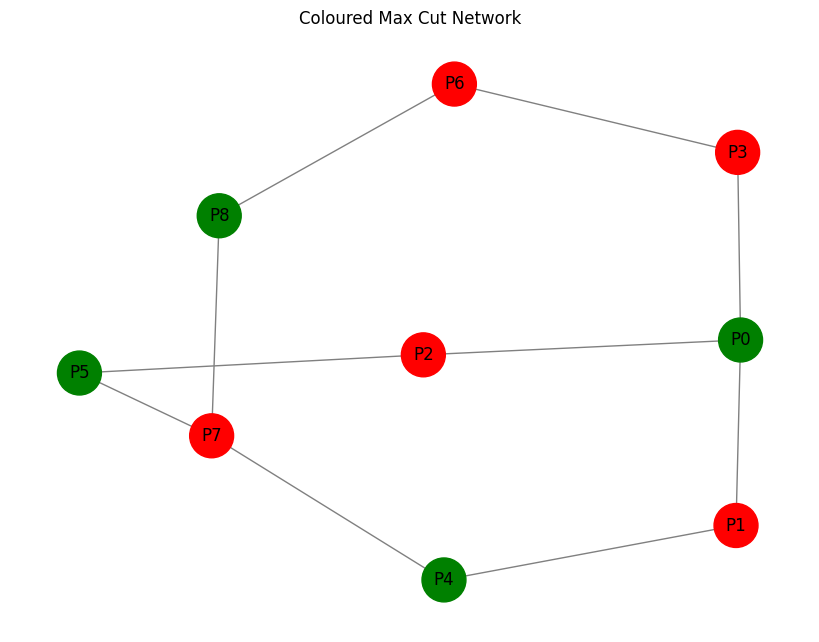

In [10]:
# Colour the nodes based on the best result
partition_dict = {}
colour = "green"
for cut in best_use_case_result["solution"]:
    partition_dict.update({node : colour for node in cut})
    colour = "red"

colours = [partition_dict[node] for node in max_cut_graph.nodes()]

# Draw the graph with new coloring
plt.figure(figsize=(8, 6))
nx.draw(max_cut_graph, pos, with_labels=True, node_color=colours, edge_color="gray", node_size=1000, font_size=12)
plt.title("Coloured Max-Cut Network")
plt.show()


Congrats! You have now solved the Set Partitioning problem using the use case library of Luna! If you are interested in finding out more about the plethora of different use cases Luna provides, we encourage you to explore the use case library!